In [1]:
import warnings

# Filter all warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lazypredict

from scipy import stats
from scipy.stats import skew

import pycaret
from pycaret.classification import (setup, compare_models, tune_model)

from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix,
                            plot_confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import RFE

import lightgbm
from lightgbm import LGBMClassifier

import xgboost
from xgboost import XGBClassifier

### Data Wrangling

In [2]:
# Read the csv file

data = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
#See how the data looks like

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
# Check the shape of the data frame

data.shape

(40000, 14)

In [5]:
# Check column types

data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [6]:
# Delete column contact since it is totally unnecessary.

# Months and dates could give us insights for data visualization. However, I'm deleting it for the modeling part

data.drop('contact', axis = 1, inplace = True)

# Rename column y

data = data.rename(columns = {data.columns[-1]: 'is_subscribed'})


In [7]:
# Calculate the value counts of the columns

In [8]:
# Marital feature

data['marital'].value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

In [9]:
# Education Feature

data['education'].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [10]:
# Campaign Feature

data['campaign'].value_counts()

1     14718
2     11153
3      4970
4      3297
5      1642
6      1228
7       699
8       526
9       318
10      262
11      197
12      154
13      131
14       93
15       83
16       78
17       69
18       51
19       44
20       43
21       35
22       23
23       22
25       22
24       20
28       16
29       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
41        2
50        2
37        2
51        1
55        1
46        1
58        1
44        1
39        1
63        1
Name: campaign, dtype: int64

In [11]:
# Job Feature

data['job'].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [12]:
# Replace the binary variables (yes/no) into numeric variables 
# Yes would be 1 and No would be 0

binary_cols = ['default', 'housing', 'loan', 'is_subscribed']

for col in binary_cols:
    print(col)
    print(data[col].value_counts())

default
no     39191
yes      809
Name: default, dtype: int64
housing
yes    24031
no     15969
Name: housing, dtype: int64
loan
no     33070
yes     6930
Name: loan, dtype: int64
is_subscribed
no     37104
yes     2896
Name: is_subscribed, dtype: int64


In [13]:
# Replace the binary variables (yes/no) into numeric variables 
# Yes would be 1 and No would be 0

for col in binary_cols:
    data[col] = data[col].replace(to_replace = 'yes', value = 1).replace(to_replace = 'no', value = 0)

In [14]:
# Check for null values

data.isna().sum()

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
day              0
month            0
duration         0
campaign         0
is_subscribed    0
dtype: int64

In [15]:
print(''' There are not null values on this dataset. Therefore, I don't need to fill NaN values. Now I am checking if
there are outliers on the numerical data by using Data Visualization techniques.
''')

 There are not null values on this dataset. Therefore, I don't need to fill NaN values. Now I am checking if
there are outliers on the numerical data by using Data Visualization techniques.



In [16]:
# Apply value counts on subscription to see the replacements

data['is_subscribed'].value_counts()

0    37104
1     2896
Name: is_subscribed, dtype: int64

In [17]:
print('''There may be some outliers in the columns. To make better visualizations
''')

There may be some outliers in the columns. To make better visualizations



### Data Visualization

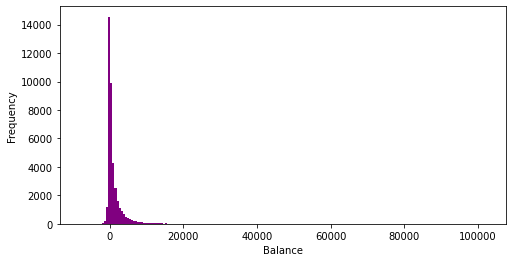

In [18]:
# Create histograms for columns such as balance and duration

plt.rcParams['figure.figsize'] = (8,4)

# Try to reduce the bins bias

n_bins = np.sqrt(len(data['balance']))
n_bins = int(n_bins)

# Plot the histogram 
data['balance'].plot(kind = 'hist', bins = n_bins, color = 'purple')
plt.xlabel('Balance')
plt.show()


In [19]:
print('''
From the histogram of balance, I can conclude that any value after roughly 15,000 would be considered as outlier 
since I can hardly observe any value after this. Therefore, 30,000 would be considered as a good threshold.
''')


From the histogram of balance, I can conclude that any value after roughly 15,000 would be considered as outlier 
since I can hardly observe any value after this. Therefore, 30,000 would be considered as a good threshold.



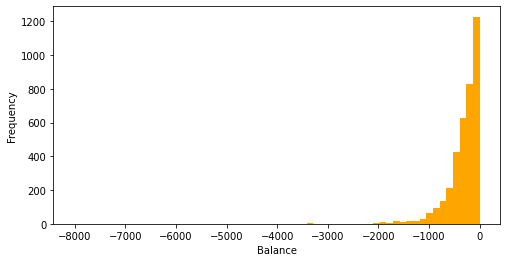

In [20]:
# See the negative values of balance

data_balance_negative = data.loc[data['balance'] < 0]

n_bins = np.sqrt(len(data_balance_negative))
n_bins = int(n_bins)

data_balance_negative['balance'].plot(kind = 'hist', bins = n_bins, color = 'orange')
plt.xlabel('Balance')
plt.show()

In [21]:
print('''
From the negative values of balance histogram, I'm also removing values less than 2000 because they look very 
unlikely
''')


From the negative values of balance histogram, I'm also removing values less than 2000 because they look very 
unlikely



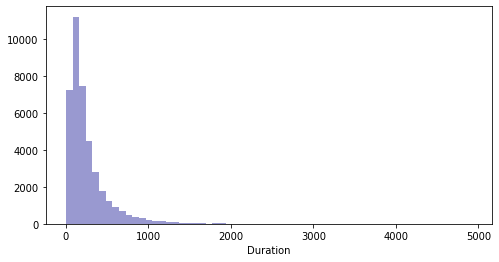

In [22]:
# Create a histogram for duration

sns.distplot(data['duration'], bins = n_bins, kde = False, color = 'darkblue')
plt.xlabel('Duration')
plt.show()

In [23]:
print('''
From the histograms of duration, I can see that any value after 2000 would be considered as outlier since I cannot
see values after this 2000 value. Therefore, 2000 would be a good theshold
''')


From the histograms of duration, I can see that any value after 2000 would be considered as outlier since I cannot
see values after this 2000 value. Therefore, 2000 would be a good theshold



In [24]:
# See if there is a value of duration less than 0 because that won't make sens

data.loc[data['duration'] < 0]

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,is_subscribed


In [25]:
print('No values of duration below 0')

No values of duration below 0


##### Plot of the histograms without the outliers

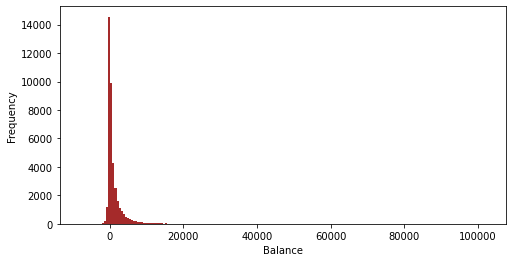

In [26]:
# Plot the new histograms for each column

n_bins = np.sqrt(len(data['balance']))
n_bins = int(n_bins)

data['balance'].plot(kind = 'hist', bins = n_bins, color = 'brown')
plt.xlabel('Balance')
plt.show()

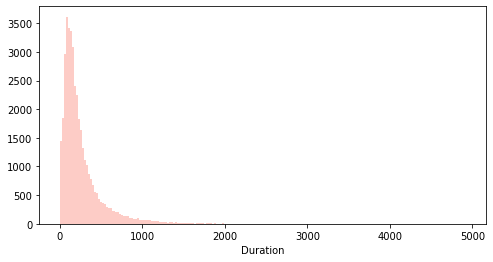

In [27]:
# Create a histogram for duration

sns.distplot(data['duration'], bins = n_bins, kde = False, color = 'salmon')
plt.xlabel('Duration')
plt.show()

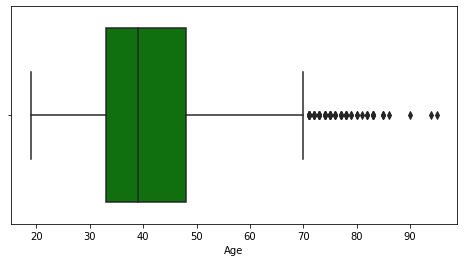

In [28]:
# Create a boxplot for the age column

sns.boxplot(x = 'age', data = data, color = 'green')
plt.xlabel('Age')
plt.show()

In [29]:
print('''
From the boxplot, it is very strange to have customers above 85, so I'm considering customers above 80 as outliers
''')


From the boxplot, it is very strange to have customers above 85, so I'm considering customers above 80 as outliers



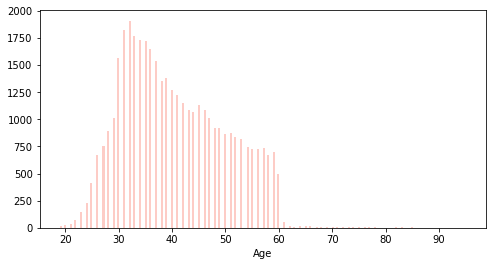

In [30]:
# Plot the histogram for age


sns.distplot(data['age'], bins = n_bins, kde = False, color = 'salmon')
plt.xlabel('Age')
plt.show()

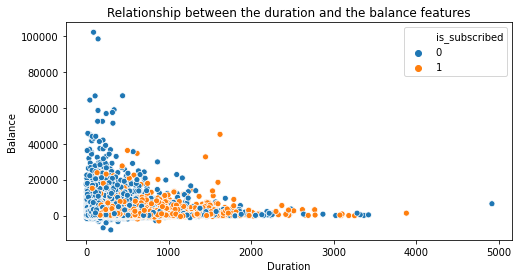

In [31]:
# I want to check out if there is any possible relation between the balance and the duration columns

sns.scatterplot(x = 'duration', y = 'balance', hue = 'is_subscribed', data = data)
plt.xlabel('Duration')
plt.ylabel('Balance')
plt.title('Relationship between the duration and the balance features')
plt.show()

In [32]:
print('''
From the scatterplot, I can see there is a tendency that the customers that are subscribed to have a higher last 
contact duration. Probably because they need to know something about the subscription, so that takes more time.
''')


From the scatterplot, I can see there is a tendency that the customers that are subscribed to have a higher last 
contact duration. Probably because they need to know something about the subscription, so that takes more time.



In [33]:
# Define a function that will grouped the data by the desired feature, and divide the subscribed and not subscribed
# customers

def grouping_df(string1):
    
    # Firstly I am creating a grouped data frame with just the subscribed customers
    
    grouped1 = data.groupby(string1).agg({'is_subscribed': 'sum'})
    
    # Secondly I am creating a grouped data frame with all the customers
    
    grouped2 = data.groupby(string1).agg({'is_subscribed': 'count'})
    
    # The data frame would be the concat of the previous two data frames
    
    grouped3 = pd.concat([grouped1, grouped2], axis = 1)
    
    # Create an additional column that would be the subtraction of the total customers and the subscribed customers
    #to get the not subscribed customers
    
    grouped3['not_subscribed'] = grouped3.iloc[:,1] - grouped3.iloc[:,0]
    
    # The final data frame would be the subscribed and the not subscribed customers
    final_grouped = grouped3.iloc[:,0:3:2]
    
    # From this function I'm returning the final data frame to analysis and visualization
    
    return final_grouped

In [34]:
# Grouping by job

job_grouped = grouping_df(string1 = 'job')

# Grouping by marital status

marital_grouped = grouping_df(string1 = 'marital')

# Grouping by education

education_grouped = grouping_df(string1 = 'education')

# Grouping by default

default_grouped = grouping_df(string1 = 'default')

# Grouping by housing

housing_grouped = grouping_df(string1 = 'housing')

# Grouping by loan

loan_grouped = grouping_df(string1 = 'loan')

# Grouping by campaign

campaign_grouped = grouping_df(string1 = 'campaign')

In [35]:
print('''
Now that I have grouped all my data frames, I'm ready to make bar chart visualizations in order to get insights from 
the categorical features I have available. Additionally, I may see some key factors of the implications that 
will make a customer to initiate a subscription.
''')


Now that I have grouped all my data frames, I'm ready to make bar chart visualizations in order to get insights from 
the categorical features I have available. Additionally, I may see some key factors of the implications that 
will make a customer to initiate a subscription.



In [36]:
# Define a function that plots a barplot that shows the number of subscribed and unsubscribed customers per each
# feature

def plot_jobs(df, c1, c2, category):
    sns.barplot(x = df.index, y = 'is_subscribed', data = df, color = c1, 
            label = 'Number of subscriptions')
    sns.barplot(x = df.index, y = 'not_subscribed', data = df, bottom = df['is_subscribed'],
           color = c2, label = 'Number of not subscribed')
    plt.xlabel(category)
    plt.ylabel('Value')
    plt.title('Number of subscribed and not subscribed customers depending on {}'.format(category))
    plt.legend(loc = 'best')
    plt.xticks(rotation = 90)
    return plt.show()

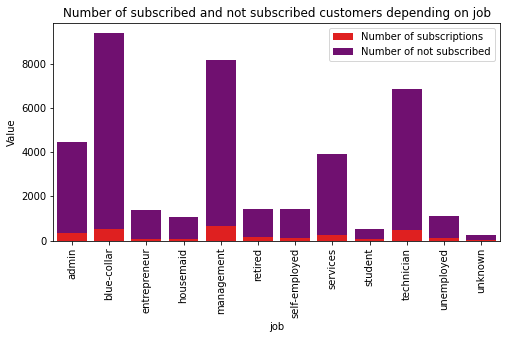

In [37]:
# Plot a bar chart to see the subscription among all the jobs

plot_jobs(df = job_grouped, c1 = 'red', c2 = 'purple', category = 'job')

In [38]:
print('''
From the dataset, the least number of subscriptions are in student, unemployed housemaid, entrepreneur, 
self-employed and delete unkown.
''')


From the dataset, the least number of subscriptions are in student, unemployed housemaid, entrepreneur, 
self-employed and delete unkown.



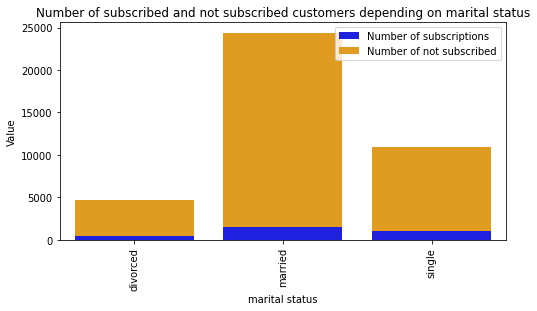

In [39]:
# Plot a bar chart to see the subscription among marital groups

plot_jobs(df = marital_grouped, c1 = 'blue', c2 = 'orange', category = 'marital status')

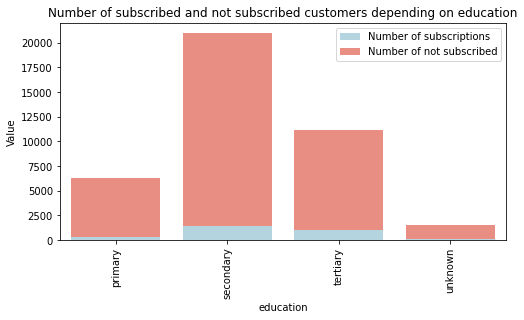

In [40]:
# Plot a bar chart to see the subscription among all the education

plot_jobs(df = education_grouped, c1 = 'lightblue', c2 = 'salmon', category = 'education')

In [41]:
print('''
From the visualization we can entirely delete unknown.
''')


From the visualization we can entirely delete unknown.



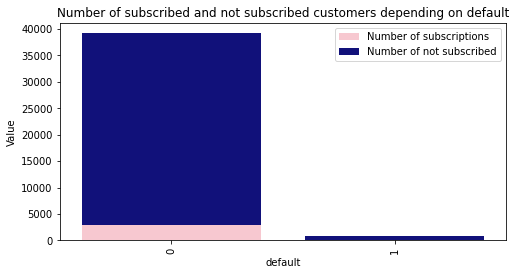

In [42]:
# Plot a bar chart to see the subscription among default

plot_jobs(df = default_grouped, c1 = 'pink', c2 = 'darkblue', category = 'default')

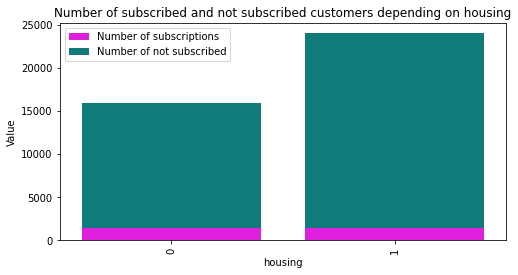

In [43]:
# Plot a bar chart to see the subscription among housing

plot_jobs(df = housing_grouped, c1 = 'magenta', c2 = 'darkcyan', category = 'housing')

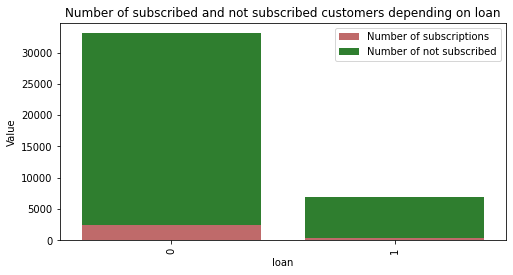

In [44]:
# Plot a bar chart to see the subscription among loans

plot_jobs(df = loan_grouped, c1 = 'indianred', c2 = 'forestgreen', category = 'loan')

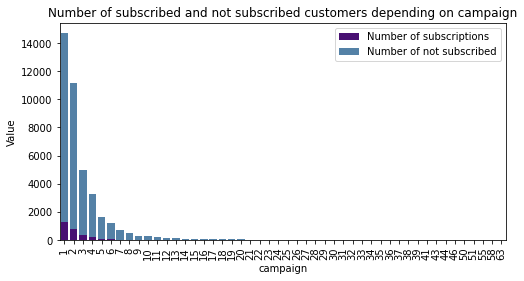

In [45]:
# Plot a bar chart to see the subscription among campaigns

plot_jobs(df = campaign_grouped, c1 = 'indigo', c2 = 'steelblue', category = 'campaign')

### Statistical Inference

In [46]:
# Establish the confidence intervals for the dependand variable is_subscribed

is_subscribed = np.array(data['is_subscribed'])

In [47]:
# I am selecting 400000 choices and include it in the bagging to then, randomly select 40.000 
# I will also calculate the average mean for each time I'm running the experiment with the bootstrapping

# Save the current mean of our dataset

is_subscribed_mean = np.mean(is_subscribed)

# Establish the number of samples that will be in our bagging
n_samples = 400000

# Save it in a variable called bagging
bagging = np.random.choice(a = is_subscribed, size = n_samples)

# Calculate 20000 different means
n_iterations = 20000

# Create an empty list where I will save all the means I get during the for loop
means = []

for i in range(n_iterations):
    sample = np.random.choice(a = bagging, size = len(is_subscribed))
    mean = np.mean(sample)
    means.append(mean)

The mean of the current dataset is 0.0724
The 95% confidence interval is located between 0.069475 and 0.074575 for the mean average 
after running 20000 repetitions for the bootstrapping.
The average mean I got was of 0.07203369250000001.
The median I got after doing the bootstrapping experiment was 0.072025.
The standard deviation I got after doing the bootstrapping was 0.0012883594958099818.


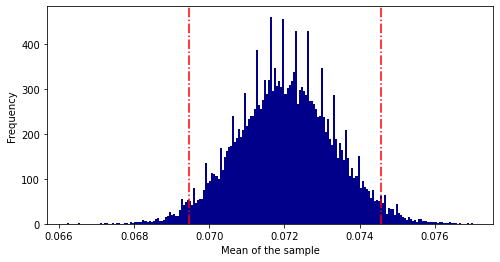

In [48]:
# Establish a confidence interval of 95% using the quantiles functions on the means list

bound1 = np.quantile(a = means, q = (2.5/100))
bound2 = np.quantile(a = means, q = (97.5/100))

print('''The mean of the current dataset is {}'''.format(is_subscribed_mean))

print('''The 95% confidence interval is located between {} and {} for the mean average 
after running 20000 repetitions for the bootstrapping.'''.format(bound1, bound2))


print('''The average mean I got was of {}.'''.format(np.mean(means)))


print('''The median I got after doing the bootstrapping experiment was {}.'''.format(np.median(means)))


print('''The standard deviation I got after doing the bootstrapping was {}.'''.format(np.std(means)))

# Plot the histogram

n_bins = np.sqrt(len(is_subscribed))
n_bins = int(n_bins)

plt.hist(x = means, bins = n_bins, color = 'darkblue')
plt.axvline(bound1, color = 'red', linestyle = '-.')
plt.axvline(bound2, color = 'red', linestyle = '-.')
plt.xlabel('Mean of the sample')
plt.ylabel('Frequency')
plt.show()



###### Formulate a Permutation  and bootstrapping test to see relation between subscription and the other binary variables

##### Null Hypothesis

###### No relation presented on the data set. This will be calculated by taking into consideration the differences on the mean. If the is_subscribed average is higher on this dataset, that won't necessarily mean that after doing the bootstrapping,  the mean of is_subscribed would continue being higher and the same if the opposite scenario is presented on the data set (if the mean of this is_subscribed feature is lower on this data set).

##### Alternative Hypothesis

###### If the current dataset presents a positive difference between the means of the feature (is_subscribed as the first feature), after doing the bootstrapping this behavior would continue. And same if the opposite scenario is presented. 

##### The lower the p-value is, that means our Null Hypothesis is weaker

In [49]:
# Firstly, I will calculate the mean for all the binary columns I have and save them in an array

default = np.array(data['default'])
default_mean = np.mean(default)

housing = np.array(data['housing'])
housing_mean = np.mean(housing)

loan = np.array(data['loan'])
loan_mean = np.mean(loan)

# Save the differences of the means between the arrays selected and the is_subscribed array

is_subscribed_default_diff = is_subscribed_mean - default_mean

is_subscribed_housing_diff = is_subscribed_mean - housing_mean

is_subscribed_loan_diff = is_subscribed_mean - loan_mean


In [50]:
print('Mean for the default feature is {}'.format(is_subscribed_default_diff))
print('Mean for the housing feature is {}'.format(is_subscribed_housing_diff))
print('Mean for the loan feature is {}'.format(is_subscribed_loan_diff))

Mean for the default feature is 0.052175000000000006
Mean for the housing feature is -0.5283749999999999
Mean for the loan feature is -0.10084999999999998


##### Boostrapping

In [51]:
# I am going to repeat the experiment again, but instead of using permutation test, I'm using bootstrapping

differences_subscribed_default = []
differences_subscribed_housing = []
differences_subscribed_loan = []

# Save the bagging where I am doing the bootstrapping for each feature
bagging_is_subscribed = np.random.choice(a = is_subscribed, size = n_samples)

bagging_default = np.random.choice(a = default, size = n_samples)

bagging_housing = np.random.choice(a = housing, size = n_samples)

bagging_loan = np.random.choice(a = loan, size = n_samples)

# Start the for loop to calculate the difference between each feature to then calculate the p-value

for i in range(n_iterations):
    # Create the sample for is_subscribed
    sample1 = np.random.choice(bagging_is_subscribed, size = len(is_subscribed))
    # Create the sample for default
    sample2 = np.random.choice(bagging_default, size = len(is_subscribed))
    # Create the sample for housing
    sample3 = np.random.choice(bagging_housing, size = len(is_subscribed))
    # Create the sample for loan
    sample4 = np.random.choice(bagging_loan, size = len(is_subscribed))
    # Calculation of the difference of the means between the dependant variable and the independant varialbes
    diff1 = np.mean(sample1) - np.mean(sample2)
    differences_subscribed_default.append(diff1)
    diff2 = np.mean(sample1) - np.mean(sample3)
    differences_subscribed_housing.append(diff2)
    diff3 = np.mean(sample1) - np.mean(sample4)
    differences_subscribed_loan.append(diff3)

In [52]:
# Calculation of the p-values

# Default

p_value1 = np.sum(np.array(differences_subscribed_default) < 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and default'''.format(p_value1))

# Housing

p_value2 = np.sum(np.array(differences_subscribed_housing) > 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and housing'''.format(p_value2))

# Loan

p_value3 = np.sum(np.array(differences_subscribed_loan) > 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and loan'''.format(p_value3))

I got a p-value of 0.0 for is_subscribed and default
I got a p-value of 0.0 for is_subscribed and housing
I got a p-value of 0.0 for is_subscribed and loan


After getting the p-values, I am able to reject my Null Hypothesis. 
Therefore, if the mean of is_subscribed is higher, more likely it would continue this way and the same if the mean of is_subscribed is lower.

###### Permutation Test

In [53]:
# For the permutation test, I'm adding both features (is_subscribed and the other one) into the same bag

# Define the function that will do the permutation test of the data

def permutation_sample(data1, data2):
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data1):]
    return perm_sample1, perm_sample2

In [54]:
# Create the empty list where the differences are doing to be added 

mean_subscribed_housing = []
mean_subscribed_default = []
mean_subscribed_loan = []

#For loop to run the experiment multiple times

for i in range(n_iterations):
    sample1, sample2 = permutation_sample(data1 = is_subscribed, data2 = housing)
    diff = np.mean(sample1) - np.mean(sample2)
    mean_subscribed_housing.append(diff)
    sample1, sample2 = permutation_sample(data1 = is_subscribed, data2 = default) 
    diff = np.mean(sample1) - np.mean(sample2)
    mean_subscribed_default.append(diff)
    sample1, sample2 = permutation_sample(data1 = is_subscribed, data2 = loan)
    diff = np.mean(sample1) - np.mean(sample2)
    mean_subscribed_loan.append(diff)

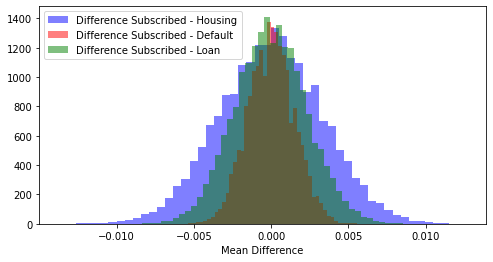

In [55]:
# Plot the three different distributions

plt.hist(mean_subscribed_housing, bins = 50, color = 'blue', alpha = 0.5, 
         label = 'Difference Subscribed - Housing')
plt.hist(mean_subscribed_default, bins = 50, color = 'red', alpha = 0.5, 
        label = 'Difference Subscribed - Default')
plt.hist(mean_subscribed_loan, bins = 50, color = 'green', alpha = 0.5,
        label = 'Difference Subscribed - Loan')
plt.xlabel('Mean Difference')
plt.legend(loc = 'best')
plt.show()

In [56]:
# Calculation of the p-value under the assumptions the variable is_subscribed were equally distributed than
# housing, default, loan respectively 

# Default

p_value1 = np.sum(np.array(mean_subscribed_default) < 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and default'''.format(p_value1))

# Housing

p_value2 = np.sum(np.array(mean_subscribed_housing) > 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and housing'''.format(p_value2))

# Loan

p_value3 = np.sum(np.array(mean_subscribed_loan) > 0)/n_iterations

print('''I got a p-value of {} for is_subscribed and loan'''.format(p_value3))

I got a p-value of 0.5039 for is_subscribed and default
I got a p-value of 0.5005 for is_subscribed and housing
I got a p-value of 0.4896 for is_subscribed and loan


##### The p-value would change if the variables were equally distributed.  This means the distribution of each variable may have an important role on the subscription variable

- The is_subscribed - housing presented higher differences on the mean 
- The is_subscribed - default had the less difference in means (which makes me think they are more similarly distributed on the original dataset)

### Feature Engineering

In [57]:
print('''
On this step, I'm organizing the data to run the different models to complete the classification problem. Firstly,
I'm calculating the skewness and kurtosis of the data and see if it is necessary to apply a transformation such as box cox.
''')


On this step, I'm organizing the data to run the different models to complete the classification problem. Firstly,
I'm calculating the skewness and kurtosis of the data and see if it is necessary to apply a transformation such as box cox.



In [58]:
print('''
The variables I will focus on are the ones who are not binary, neither categorical nor dates or ages. Saying this, I 
would primarily focus on the numeric variables to apply any kind of transformation.
''')


The variables I will focus on are the ones who are not binary, neither categorical nor dates or ages. Saying this, I 
would primarily focus on the numeric variables to apply any kind of transformation.



#### Outliers removal

###### Month feature

In [59]:
# Check out the unique values for the months feature
data['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

In [60]:
# Change the month to numeric variables and then convert the feature into categorical feature
# Remove days from the dataset since all months have the same number of dates. It would be more useful to know
# if just months have the influence on number of subscription

data['month'] = data['month'].replace(to_replace = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                    'oct', 'nov', 'dec'], value = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12])


In [61]:
# Have the data quarterly ( 1st, 2nd, 3rd and 4th quarter of the year)

months_col = []

for i in data['month'].values:
    if ( i == 1) or (i ==2) or (i ==3) or (i==4):
        value = 1
        months_col.append(value)
    else:
        value = 0
        months_col.append(value)

In [62]:
# Drop the existing months column

data = data.drop('month', axis = 1)

# Add the new categorical column

data['first_half'] = months_col

###### Balance feature

In [63]:
# Removal of outliers

# Removal of the balance outliers

# Calculation of the first and third quantile

q1 = data['balance'].quantile(0.25)
q3 = data['balance'].quantile(0.75)

# Calculation of the Interquartile Range

iqr = q3 - q1

# Removal of the outliers using the thumbs up rule

condition1 = data['balance'] > q1 - (1.5*iqr)
condition2 = data['balance'] < q3 + (1.5*iqr)

data = data.loc[condition1 & condition2]


###### Duration feature

In [64]:
# Removal of outliers

# Removal of the balance outliers

# Calculation of the first and third quantile

q1 = data['duration'].quantile(0.25)
q3 = data['duration'].quantile(0.75)

# Calculation of the Interquartile Range

iqr = q3 - q1

# Removal of the outliers using the thumbs up rule

condition1 = data['duration'] > q1 - (1.5*iqr)
condition2 = data['duration'] < q3 + (1.5*iqr)

data = data.loc[condition1 & condition2]

###### Age feature

In [65]:
# Removal of the age outliers

condition4 = data['age'] < 75

data = data.loc[condition4]

# Reset the index

data.reset_index(drop = True, inplace = True)

In [66]:
# Divide the age column in three intervals age

min_value = data['age'].min()
max_value = data['age'].max()

interval_age = int((max_value - min_value)/3)

print('The maximum age is {}'.format(max_value))
print('The minimum age is {}'.format(min_value))
print('The interval age is {}'.format(interval_age))

The maximum age is 74
The minimum age is 19
The interval age is 18


In [67]:
print('First interval is between {} and {}'.format(min_value, min_value + interval_age))
print('Second interval is between {} and {}'.format(min_value + interval_age + 1, max_value - interval_age))
print('Third interval is between {} and {}'.format(max_value - interval_age +1, max_value))

First interval is between 19 and 37
Second interval is between 38 and 56
Third interval is between 57 and 74


In [68]:
# Create a for loop to replace values

# Create an empty list where I am storing the values
age_col = []

for i in data['age'].values:
    if (i >= 19) and (i <= 37):
        value = '19 - 37'
        age_col.append(value)
    elif (i > 37) and (i <= 56):
        value = '38 - 56'
        age_col.append(value)
    elif (i > 56) and (i <= 74):
        value = '57 - 74'
        age_col.append(value)

In [69]:
# Add the new age column

data['age_1'] = age_col


In [70]:
# See the bar plot for the age

age_grouped = grouping_df(string1 = 'age_1')

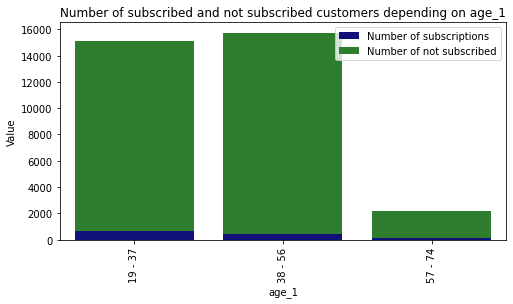

In [71]:
# Plot a bar chart to see the subscription among ages

plot_jobs(df = age_grouped, c1 = 'darkblue', c2 = 'forestgreen', category = 'age_1')

In [72]:
# From the bar chart it would be probably better to divide in two categories

interval_age = int((max_value - min_value)/2)

# Create a for loop to replace values

# Create an empty list where I am storing the values
age_col = []

for i in data['age'].values:
    if (i >= 19) and (i <= min_value + interval_age):
        value = 1
        age_col.append(value)
    else:
        value = 0
        age_col.append(value)
        
        
# Drop the age column

data = data.drop('age', axis = 1)
data = data.drop('age_1', axis = 1)

# Add the new age column

data['19-46'] = age_col

In [73]:
# See the bar plot for the age

age_grouped = grouping_df(string1 = '19-46')

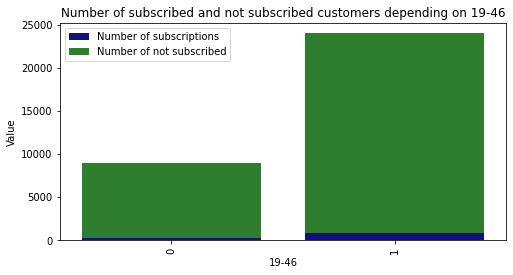

In [74]:
# Plot a bar chart to see the subscription among ages

plot_jobs(df = age_grouped, c1 = 'darkblue', c2 = 'forestgreen', category = '19-46')

###### Campaign Feature

In [75]:
# Remove the values of campaign with very little observations

data = data.loc[~data['campaign'].isin(np.arange(14, 64, 1))]

In [76]:
# Divide the categorical variable campaign into seven different categories
# Categories: Campaign 1, Campaign 2, Campaign 3,Campaign 4,Campaign 5,Campaign 6, Other

# Create an empty list to storage the values of campaign

campaign_col = []

for i in data['campaign'].values:
    if i == 1:
        value = 'Campaign 1'
        campaign_col.append(value)
    elif i == 2:
        value = 'Campaign 2'
        campaign_col.append(value)
    elif i == 3:
        value = 'Campaign 3'
        campaign_col.append(value)
    elif i == 4:
        value = 'Campaign 4'
        campaign_col.append(value)
    elif i == 5:
        value = 'Campaign 5'
        campaign_col.append(value)
    elif i == 6:
        value = 'Campaign 6'
        campaign_col.append(value)
    else:
        value = 'Other'
        campaign_col.append(value)

In [77]:
# Remove the existant column of campaign

data = data.drop('campaign', axis = 1)

# Add the new campaign column

data['campaign'] = campaign_col

###### Job feature

In [78]:
# Remove students and unknow from the job feature since there is very small data

data = data.loc[~data['job'].isin(['unknown'])]


# Divide the job fature into 6 categories
# Categories: blue-collar, management, technician, admin, services, other

job_col = []

for i in data['job'].values:
    if i == 'blue-collar':
        value = 'blue-collar'
        job_col.append(value)
    elif i == 'management':
        value = 'management'
        job_col.append(value)
    elif i == 'technician':
        value = 'technician'
        job_col.append(value)
    elif i == 'admin':
        value = 'admin'
        job_col.append(value)
    elif i == 'services':
        value = 'services'
        job_col.append(value)
    else:
        value = 'other'
        job_col.append(value)
    

# Delete the current job column

data = data.drop('job', axis = 1)

# Add the new job column

data['job'] = job_col


###### Education Feature

In [79]:
# Remove the unknown education

data = data.loc[~data['education'].isin(['unknown'])]

###### New Value Counts

In [80]:
# Marital Status Feature

data['marital'].value_counts()

married     18847
single       8462
divorced     3780
Name: marital, dtype: int64

In [81]:
# Education Feature

data['education'].value_counts()

secondary    17344
tertiary      8683
primary       5062
Name: education, dtype: int64

In [82]:
# Age Feature

data['19-46'].value_counts()

1    22773
0     8316
Name: 19-46, dtype: int64

In [83]:
# Campaign Feature

data['campaign'].value_counts()

Campaign 1    11659
Campaign 2     8784
Campaign 3     3892
Campaign 4     2628
Other          1817
Campaign 5     1349
Campaign 6      960
Name: campaign, dtype: int64

In [84]:
# Job Feature

data['job'].value_counts()

blue-collar    7375
management     6178
technician     5392
other          5294
admin          3669
services       3181
Name: job, dtype: int64

In [85]:
# Season of the year Feature

data['first_half'].value_counts()

0    25987
1     5102
Name: first_half, dtype: int64

##### Skewness Issue

In [86]:
# Check out for the skewness

data.skew()

default          6.482137
balance          1.283503
housing         -0.460889
loan             1.610365
day              0.096089
duration         1.025496
is_subscribed    4.913782
first_half       1.813874
19-46           -1.050586
dtype: float64

Highly Skewed Data:
1. Default - Binary
2. Balance -  Numeric
3. Loan -  Binary 
4. Duration -  Numeric Variable
5. Campaign -  Categorical Variable

Aprroximately Uniform Distribution
1. Housing - Binary
2. Day -  Date time in categorical feature
3. Age - Numeric Variable but it is age

In [87]:
# Check out for the kurtosis
data.kurtosis()

default          40.020678
balance           1.418021
housing          -1.787696
loan              0.593314
day              -1.074242
duration          0.496691
is_subscribed    22.146683
first_half        1.290222
19-46            -0.896326
dtype: float64

Leptokurtic Distributions (Tails fatter than the normal Distribution and the value is greater than 3)

1. Default - Binary 
2. Balance - Numeric
3. Duration - Numeric
4. Campaign - Category

Platykurtic (Tails are thinner and the value is lower than 3)
1. Age - Numeric (but age)
2. Housing - Binary
3. Loan - Binary
4. Day -  Numeric but in categorical

In [88]:
print(''' I need to make some transformation techniques in some of the features before doing the modeling because the
values of Skewness and Kurtosis were very far from a normal distribution.
''')

print('''The variables I will work are: Balance and Duration''')

 I need to make some transformation techniques in some of the features before doing the modeling because the
values of Skewness and Kurtosis were very far from a normal distribution.

The variables I will work are: Balance and Duration


In [89]:
# Apply different techniques to reduce the skewness on the balance features 

y = list(data['balance'].values)

y1 = []

# Square root method
for num in y:
    if num < 0:
        num = num * (-1)
        num = num ** (1/2)
        num = num * (-1)
     
    else:
        num = num ** (1/2)
        
    y1.append(num)

In [90]:
# Cube root method (I needed to do this because of the negative values)

y2 = []

# Cube root method

for num in y:
    if num < 0:
        num = num * (-1)
        num = num ** (1/3)
        num = num * (-1)
     
    else:
        num = num ** (1/3)
        
    y2.append(num)

In [91]:
# Convert them into numpy array

y1 = np.array(y1)
y2 = np.array(y2)

In [92]:
# Calculation of the skewness for the normalized data

print('y1 has a skewness of {}'.format(skew(y1)))

print('y2 has a skewness of {}'.format(skew(y2)))

y1 has a skewness of -0.16324270932910817
y2 has a skewness of -0.8498021285963606


In [93]:
# Drop the column duration and balance, and add the normalized data

data = data.drop('balance', axis = 1)

data['balance'] = y1


###### Transform the dataset into categorical for modeling

In [94]:
# Apply dummy features of pandas to have the columns as category. 
# Balance and duration won't be categorical

category_features = data[['job', 'marital', 'education', 'campaign']]

# Select the non categorical features
data_modeling = data[['default','balance', 'housing', 'loan', 'duration', 'is_subscribed', 'first_half', '19-46']]

dummies = pd.get_dummies(data = category_features, columns = ['job', 'marital', 'education', 
                                                              'campaign'])

# Concat the categorical features with the non categorical

data_modeling = pd.concat([data_modeling, dummies], axis = 1)


In [95]:
data_modeling.head()

,default,balance,housing,loan,duration,is_subscribed,first_half,19-46,job_admin,job_blue-collar,job_management,job_other,job_services,job_technician,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,campaign_Campaign 1,campaign_Campaign 2,campaign_Campaign 3,campaign_Campaign 4,campaign_Campaign 5,campaign_Campaign 6,campaign_Other
0,0,46.292548,1,0,261,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
1,0,5.385165,1,0,151,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0
2,0,1.414214,1,1,76,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
5,0,15.198684,1,0,139,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
6,0,21.142375,1,1,217,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0


In [96]:
data_modeling.columns

Index(['default', 'balance', 'housing', 'loan', 'duration', 'is_subscribed',
       'first_half', '19-46', 'job_admin', 'job_blue-collar', 'job_management',
       'job_other', 'job_services', 'job_technician', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'campaign_Campaign 1',
       'campaign_Campaign 2', 'campaign_Campaign 3', 'campaign_Campaign 4',
       'campaign_Campaign 5', 'campaign_Campaign 6', 'campaign_Other'],
      dtype='object')

In [97]:
data_modeling.shape

(31089, 27)

###### Resample the dataset into 50% of subscribed and 50% with no subscription

In [98]:
# Divide the data_modeling into subscribed and not subscribed (restricting this one to the length of the subscribed)

data_modeling_subscribed = data_modeling.loc[data_modeling['is_subscribed'] == 1].reset_index(drop = True)

data_modeling_not_subscribed = data_modeling.loc[data_modeling['is_subscribed'] == 0].reset_index(drop = True)

In [99]:
# Initiate the bagging for both data frames

#Create an array with the values

initial_sample_subscribed = data_modeling_subscribed.values

# Create an empty list called bagging where I will add all the values for the bootstrapping

bagging_subscribed = []

#Establish the number of times I will run the experiment over and over again

n_iterations = len(initial_sample_subscribed) * 7

# Start a for loop to initiate the bootstrapping (Run 7 times the experiment)

for i in range(n_iterations):
    idx = np.random.choice(len(initial_sample_subscribed))
    sample = initial_sample_subscribed[idx]
    bagging_subscribed.append(sample)

In [100]:
#Create an array with the values of not subscribed

initial_sample_not_subscribed = data_modeling_not_subscribed.values

# Create an empty list called bagging where I will add all the values for the bootstrapping

bagging_not_subscribed = []

#Establish the number of times I will run the experiment over and over again

n_iterations = len(initial_sample_not_subscribed) * 7

# Start a for loop to initiate the bootstrapping (Run 7 times the experiment)

for i in range(n_iterations):
    idx = np.random.choice(len(initial_sample_not_subscribed))
    sample = initial_sample_not_subscribed[idx]
    bagging_not_subscribed.append(sample)

In [101]:
# Select randomly from both bagging list the values to run the experiment

number_samples = len(initial_sample_subscribed)

values_subscribed = []

values_not_subscribed = []

# Create the for loop to  select the samples in the subscribed part

for i in range(number_samples):
    idx = np.random.choice(len(bagging_subscribed))
    sample = bagging_subscribed[idx]
    values_subscribed.append(sample)
      
# Create the for loop for the not subscribed part

for i in range(number_samples):
    idx = np.random.choice(len(bagging_not_subscribed))
    sample = bagging_not_subscribed[idx]
    values_not_subscribed.append(sample)

In [102]:
# Create a new data frame with the values

data_modeling_subscribed = pd.DataFrame(values_subscribed)

data_modeling_not_subscribed = pd.DataFrame(values_not_subscribed)

# Concat both data framens horizontally

data_modeling_balanced = pd.concat([data_modeling_subscribed, data_modeling_not_subscribed], axis = 0)

#Name the columns

data_modeling_balanced.columns = data_modeling.columns

In [103]:
# Check the data frame is correctly balanced

data_modeling_balanced['is_subscribed'].value_counts()

0.0    1147
1.0    1147
Name: is_subscribed, dtype: int64

###### Feature Selection

In [104]:
# Get the dependant and independant feature(s)

X = data_modeling_balanced.drop('is_subscribed', axis = 1).values

y = data_modeling_balanced['is_subscribed'].values

# Divide into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, shuffle = True)

In [105]:
data_modeling_balanced.head()

,default,balance,housing,loan,duration,is_subscribed,first_half,19-46,job_admin,job_blue-collar,job_management,job_other,job_services,job_technician,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,campaign_Campaign 1,campaign_Campaign 2,campaign_Campaign 3,campaign_Campaign 4,campaign_Campaign 5,campaign_Campaign 6,campaign_Other
0,0.0,51.855569,1.0,0.0,135.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20.223748,0.0,0.0,115.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,14.594520,0.0,0.0,378.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,53.065997,0.0,0.0,327.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,25.961510,0.0,0.0,483.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# Start the feature selection

# Define RFE

rfe_dt = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=20)

rfe_rf = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)

rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20)

# fit RFE

rfe_dt.fit(X_train, y_train)

rfe_rf.fit(X_train, y_train)

rfe_gb.fit(X_train, y_train)

# Create a list with the features

features = list(data_modeling_balanced.columns)

index = features.index('is_subscribed')

features.pop(index)

# Create an empty list to see if the feature was selected

is_selected_dt = []

is_selected_rf = []

is_selected_gb = []

# Create an empty list with the rank

ranks_dt = []

ranks_rf = []

ranks_gb = []

# Summarize all features

for i in range(X.shape[1]):
    is_selected_value = rfe_dt.support_[i]
    is_selected_dt.append(is_selected_value)
    rank = rfe_dt.ranking_[i]
    ranks_dt.append(rank)
    
for i in range(X.shape[1]):
    is_selected_value = rfe_rf.support_[i]
    is_selected_rf.append(is_selected_value)
    rank = rfe_rf.ranking_[i]
    ranks_rf.append(rank)    
    
for i in range(X.shape[1]):
    is_selected_value = rfe_gb.support_[i]
    is_selected_gb.append(is_selected_value)
    rank = rfe_gb.ranking_[i]
    ranks_gb.append(rank)    

In [107]:
# Define a function that will sort the ranks of each feature and if the feature was selected

def df_converter(is_selected, ranks):
    feature_selection = pd.DataFrame()
    feature_selection['Feature'] = features
    feature_selection['is_selected'] = is_selected
    feature_selection['ranks'] = ranks
    sorted_ranks = feature_selection.sort_values(by = 'ranks', ascending = True).reset_index(drop = True)
    return sorted_ranks

In [108]:
# Use pycaret to have an understanding of what models work better

# Function that converts the arrays created to data frame

def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependant'] = train_dependent
    return df

In [109]:
# Create the data frame for the train data

df = converter_df(train_independent = X_train, train_dependent = y_train)

In [110]:
# Setup the dataset

grid = setup(data = df, target = df.columns[-1], html = False, silent = True, verbose = False)

# Evaluate models and compare models

best = compare_models()

# Report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.583,0.493


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.583,0.493
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.373,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024
qda,Quadratic Discriminant Analysis,0.4721,0.4766,0.6983,0.4718,0.5552,-0.0465,-0.0539,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024
qda,Quadratic Discriminant Analysis,0.4721,0.4766,0.6983,0.4718,0.5552,-0.0465,-0.0539,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024
qda,Quadratic Discriminant Analysis,0.4721,0.4766,0.6983,0.4718,0.5552,-0.0465,-0.0539,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077
svm,SVM - Linear Kernel,0.6212,0.0000,0.5966,0.5182,0.5024,0.2381,0.2776,0.024


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
et,Extra Trees Classifier,0.8071,0.8953,0.8220,0.7956,0.8070,0.6143,0.6172,0.301
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022
knn,K Neighbors Classifier,0.6857,0.7520,0.7085,0.6714,0.6889,0.3719,0.3730,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
xgboost,Extreme Gradient Boosting,0.8229,0.8894,0.8508,0.8031,0.8248,0.6461,0.6498,0.380
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
et,Extra Trees Classifier,0.8071,0.8953,0.8220,0.7956,0.8070,0.6143,0.6172,0.301
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089
nb,Naive Bayes,0.6891,0.7761,0.7898,0.6523,0.7138,0.3806,0.3899,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8321,0.8906,0.8695,0.8074,0.8355,0.6646,0.6696,0.063
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
xgboost,Extreme Gradient Boosting,0.8229,0.8894,0.8508,0.8031,0.8248,0.6461,0.6498,0.380
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
et,Extra Trees Classifier,0.8071,0.8953,0.8220,0.7956,0.8070,0.6143,0.6172,0.301
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022
ada,Ada Boost Classifier,0.7714,0.8488,0.7508,0.7788,0.7624,0.5424,0.5456,0.089


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8338,0.8974,0.8610,0.8142,0.8352,0.6677,0.6718,1.767
lightgbm,Light Gradient Boosting Machine,0.8321,0.8906,0.8695,0.8074,0.8355,0.6646,0.6696,0.063
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
xgboost,Extreme Gradient Boosting,0.8229,0.8894,0.8508,0.8031,0.8248,0.6461,0.6498,0.380
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
et,Extra Trees Classifier,0.8071,0.8953,0.8220,0.7956,0.8070,0.6143,0.6172,0.301
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8338,0.8974,0.8610,0.8142,0.8352,0.6677,0.6718,1.767
lightgbm,Light Gradient Boosting Machine,0.8321,0.8906,0.8695,0.8074,0.8355,0.6646,0.6696,0.063
rf,Random Forest Classifier,0.8287,0.9062,0.8559,0.8099,0.8302,0.6577,0.6624,0.348
xgboost,Extreme Gradient Boosting,0.8229,0.8894,0.8508,0.8031,0.8248,0.6461,0.6498,0.380
gbc,Gradient Boosting Classifier,0.8080,0.8790,0.8356,0.7889,0.8099,0.6162,0.6203,0.103
et,Extra Trees Classifier,0.8071,0.8953,0.8220,0.7956,0.8070,0.6143,0.6172,0.301
ridge,Ridge Classifier,0.7905,0.0000,0.7763,0.7937,0.7826,0.5806,0.5842,0.020
lda,Linear Discriminant Analysis,0.7905,0.8640,0.7763,0.7937,0.7826,0.5806,0.5842,0.026
lr,Logistic Regression,0.7897,0.8624,0.7797,0.7909,0.7826,0.5791,0.5830,0.493
dt,Decision Tree Classifier,0.7897,0.7901,0.8136,0.7726,0.7912,0.5796,0.5827,0.022


In [111]:
print('''
Random Forest Classifier may be the best model that predicts the subscription of the customers

''')


Random Forest Classifier may be the best model that predicts the subscription of the customers




In [112]:
# Feature Selection for Decision Tree Classifier

df_converter(is_selected = is_selected_dt, ranks = ranks_dt)

,Feature,is_selected,ranks
0,job_technician,True,1
1,campaign_Campaign 5,True,1
2,campaign_Campaign 3,True,1
3,campaign_Campaign 2,True,1
4,campaign_Campaign 1,True,1
5,education_tertiary,True,1
6,education_secondary,True,1
7,education_primary,True,1
8,marital_single,True,1
9,marital_married,True,1


In [113]:
# Feature Selection for Random Forest Classifier

df_converter(is_selected = is_selected_rf, ranks = ranks_rf)

,Feature,is_selected,ranks
0,job_technician,True,1
1,campaign_Campaign 1,True,1
2,education_tertiary,True,1
3,education_secondary,True,1
4,education_primary,True,1
5,marital_single,True,1
6,marital_married,True,1
7,job_services,True,1
8,campaign_Campaign 2,True,1
9,job_other,True,1


In [114]:
# Feature selection for Gradient Boosting Classifier

df_converter(is_selected = is_selected_gb, ranks = ranks_gb)

,Feature,is_selected,ranks
0,job_technician,True,1
1,campaign_Campaign 2,True,1
2,campaign_Campaign 1,True,1
3,education_tertiary,True,1
4,education_primary,True,1
5,marital_single,True,1
6,marital_married,True,1
7,marital_divorced,True,1
8,campaign_Campaign 6,True,1
9,job_other,True,1


In [115]:
print('''
From the feature selection I could get some insights to make the data with less features. I can make campaign 4,5, 6 
and other into the same category.
''')


From the feature selection I could get some insights to make the data with less features. I can make campaign 4,5, 6 
and other into the same category.



In [116]:
# Make the changes

campaign_cols = []

for i in data['campaign'].values:
    if (i == 'Campaign 4') or (i == 'Campaign 5') or (i == 'Campaign 6') or (i == 'Other'):
        value = 'Other'
        campaign_cols.append(value)
    else:
        campaign_cols.append(i)


In [117]:
# Drop the existing campaign col and add the new one

data = data.drop('campaign', axis = 1)

data['campaign'] = campaign_cols

In [118]:
# Do again the dummies pandas function

# Apply dummy features of pandas to have the columns as category. 
# Balance and duration won't be categorical

category_features = data[['job', 'marital', 'education', 'campaign']]

# Select the non categorical features
data_modeling = data[['default','balance', 'housing', 'loan', 'duration', 'is_subscribed', 'first_half', '19-46']]

dummies = pd.get_dummies(data = category_features, columns = ['job', 'marital', 'education', 
                                                              'campaign'])

# Concat the categorical features with the non categorical

data_modeling = pd.concat([data_modeling, dummies], axis = 1)

###### Resample the dataset into 50% of subscribed and 50% with no subscription again

In [119]:
# Divide the data_modeling into subscribed and not subscribed (restricting this one to the length of the subscribed)

data_modeling_subscribed = data_modeling.loc[data_modeling['is_subscribed'] == 1].reset_index(drop = True)

data_modeling_not_subscribed = data_modeling.loc[data_modeling['is_subscribed'] == 0].reset_index(drop = True)

In [120]:
# Initiate the bagging for both data frames

#Create an array with the values

initial_sample_subscribed = data_modeling_subscribed.values

# Create an empty list called bagging where I will add all the values for the bootstrapping

bagging_subscribed = []

#Establish the number of times I will run the experiment over and over again

n_iterations = len(initial_sample_subscribed) * 7

# Start a for loop to initiate the bootstrapping (Run 7 times the experiment)

for i in range(n_iterations):
    idx = np.random.choice(len(initial_sample_subscribed))
    sample = initial_sample_subscribed[idx]
    bagging_subscribed.append(sample)

In [121]:
#Create an array with the values of not subscribed

initial_sample_not_subscribed = data_modeling_not_subscribed.values

# Create an empty list called bagging where I will add all the values for the bootstrapping

bagging_not_subscribed = []

#Establish the number of times I will run the experiment over and over again

n_iterations = len(initial_sample_not_subscribed) * 7

# Start a for loop to initiate the bootstrapping (Run 7 times the experiment)

for i in range(n_iterations):
    idx = np.random.choice(len(initial_sample_not_subscribed))
    sample = initial_sample_not_subscribed[idx]
    bagging_not_subscribed.append(sample)

In [122]:
# Select randomly from both bagging list the values to run the experiment

number_samples = len(initial_sample_subscribed)

values_subscribed = []

values_not_subscribed = []

# Create the for loop to  select the samples in the subscribed part

for i in range(number_samples):
    idx = np.random.choice(len(bagging_subscribed))
    sample = bagging_subscribed[idx]
    values_subscribed.append(sample)
      
# Create the for loop for the not subscribed part

for i in range(number_samples):
    idx = np.random.choice(len(bagging_not_subscribed))
    sample = bagging_not_subscribed[idx]
    values_not_subscribed.append(sample)

In [123]:
# Create a new data frame with the values

data_modeling_subscribed = pd.DataFrame(values_subscribed)

data_modeling_not_subscribed = pd.DataFrame(values_not_subscribed)

# Concat both data framens horizontally

data_modeling_balanced = pd.concat([data_modeling_subscribed, data_modeling_not_subscribed], axis = 0)

#Name the columns

data_modeling_balanced.columns = data_modeling.columns

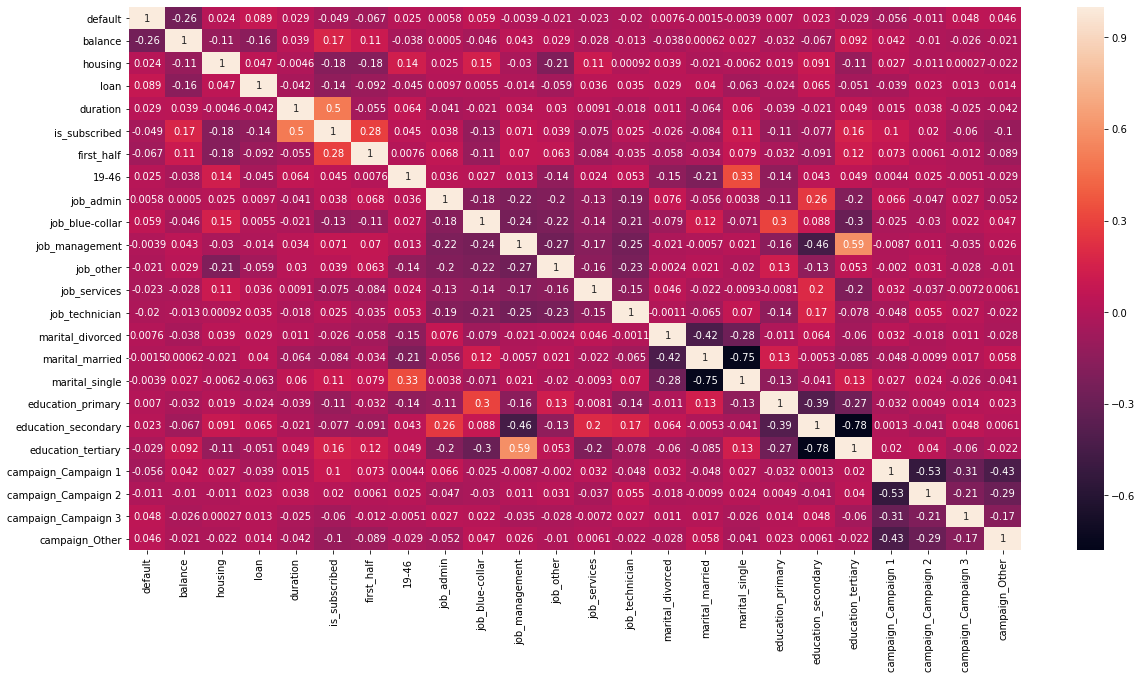

In [124]:
# Plot the correlation matrix

plt.figure(figsize=(20,10))

corr_matrix = data_modeling_balanced.corr()

sns.heatmap(corr_matrix, annot = True)
plt.show()

In [125]:
# Get the dependant and independant feature(s)

X = data_modeling_balanced.drop('is_subscribed', axis = 1).values

y = data_modeling_balanced['is_subscribed'].values

# Divide into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [126]:
# Establish the new data frame
df = converter_df(train_independent = X_train, train_dependent = y_train)

In [127]:
# Setup the dataset

grid = setup(data = df, target = df.columns[-1], html = False, silent = True, verbose = False)

# Evaluate models and compare models

best = compare_models()

# Report the best model

print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018
qda,Quadratic Discriminant Analysis,0.5096,0.5107,0.3824,0.4681,0.3712,0.0215,0.0254,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018
qda,Quadratic Discriminant Analysis,0.5096,0.5107,0.3824,0.4681,0.3712,0.0215,0.0254,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018
qda,Quadratic Discriminant Analysis,0.5096,0.5107,0.3824,0.4681,0.3712,0.0215,0.0254,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014
svm,SVM - Linear Kernel,0.6856,0.0000,0.8815,0.6504,0.7404,0.3687,0.4159,0.018


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
et,Extra Trees Classifier,0.8155,0.8898,0.8321,0.8106,0.8203,0.6308,0.6325,0.325
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077
nb,Naive Bayes,0.7191,0.7913,0.7978,0.6926,0.7409,0.4375,0.4440,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
et,Extra Trees Classifier,0.8155,0.8898,0.8321,0.8106,0.8203,0.6308,0.6325,0.325
xgboost,Extreme Gradient Boosting,0.8147,0.8850,0.8584,0.7940,0.8241,0.6290,0.6327,0.335
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016
knn,K Neighbors Classifier,0.7273,0.7819,0.7545,0.7200,0.7361,0.4543,0.4558,0.077


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
lightgbm,Light Gradient Boosting Machine,0.8188,0.8826,0.8533,0.8018,0.8263,0.6374,0.6395,0.062
et,Extra Trees Classifier,0.8155,0.8898,0.8321,0.8106,0.8203,0.6308,0.6325,0.325
xgboost,Extreme Gradient Boosting,0.8147,0.8850,0.8584,0.7940,0.8241,0.6290,0.6327,0.335
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080
dt,Decision Tree Classifier,0.7739,0.7736,0.8119,0.7595,0.7837,0.5475,0.5506,0.016


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
catboost,CatBoost Classifier,0.8321,0.8918,0.8865,0.8027,0.8420,0.6639,0.6686,1.553
lightgbm,Light Gradient Boosting Machine,0.8188,0.8826,0.8533,0.8018,0.8263,0.6374,0.6395,0.062
et,Extra Trees Classifier,0.8155,0.8898,0.8321,0.8106,0.8203,0.6308,0.6325,0.325
xgboost,Extreme Gradient Boosting,0.8147,0.8850,0.8584,0.7940,0.8241,0.6290,0.6327,0.335
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8329,0.9070,0.8798,0.8078,0.8417,0.6655,0.6692,0.348
catboost,CatBoost Classifier,0.8321,0.8918,0.8865,0.8027,0.8420,0.6639,0.6686,1.553
lightgbm,Light Gradient Boosting Machine,0.8188,0.8826,0.8533,0.8018,0.8263,0.6374,0.6395,0.062
et,Extra Trees Classifier,0.8155,0.8898,0.8321,0.8106,0.8203,0.6308,0.6325,0.325
xgboost,Extreme Gradient Boosting,0.8147,0.8850,0.8584,0.7940,0.8241,0.6290,0.6327,0.335
gbc,Gradient Boosting Classifier,0.8146,0.8835,0.8567,0.7938,0.8237,0.6290,0.6317,0.093
ridge,Ridge Classifier,0.7872,0.0000,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lda,Linear Discriminant Analysis,0.7872,0.8711,0.7893,0.7901,0.7891,0.5745,0.5754,0.016
lr,Logistic Regression,0.7856,0.8707,0.7877,0.7881,0.7875,0.5711,0.5718,0.091
ada,Ada Boost Classifier,0.7839,0.8612,0.7745,0.7926,0.7830,0.5679,0.5686,0.080


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7166, verbose=0,
                       warm_start=False)


### Modeling

On this modeling part, I'll be using some of the best models I got from the previous step. I'll use weak classifiers to have an understanding of what are the most important features and then, I'll pick up the model with best performance. I'll also use Cross Validation to try preventing any data leakage and preventing overfitting. Each method will tell me something, but at the end, I'll be selecting the method with the highest accuracy, F-1 score and the model that can reduce the type I and type II error. 

To evaluate the models, I'll be using a confussion matrix, I'll also plotting the roc curve and besides, I'll also print a classification report to see how the model performs with unseen data.

###### Modelis I'll use:

1. Logistic Regression
2. Decision Tree Classifier
4. Random Forest Classifier
3. Extra Trees Classifier
5. Gradient Boosting Classifier
6. Ada Boost Classifier
8. Light Gradient Boosting Machine
9. Extreme Gradient Boosting Classifier

In [128]:
# Define a function that will return the best hyperparamenters after doing the GridSearch Cross Validation

def grid_search(model, grid):
    model_cv = GridSearchCV(estimator = model, param_grid = grid, cv = 5)
    model_cv.fit(X_train, y_train)
    return (model_cv.best_params_)

In [129]:
# Create the parameter grid in order to select the best hyperparameters for this model in order to increase the 
#test score

param_grid_lr = {'penalty': ['l2', 'l1', None],
             'tol': [0.0001, 0.001, 0.01, 0.1, 1.0],
             'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
             'max_iter': [50, 100, 200]
             }

print(grid_search(model = LogisticRegression(), grid = param_grid_lr))

{'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'tol': 0.0001}


In [132]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = LogisticRegression(C = 0.01, max_iter = 200, penalty = 'l2', tol = 1.0), 
                         X = X_train, y = y_train, cv=5)

print(scores)

[0.78197674 0.77325581 0.77906977 0.76162791 0.74418605]


In [133]:
def model_fit(model):
    m = model
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    return m, pred

In [134]:
# Fit and predict the values using the model with the best hyperparameters

lr, lr_pred = model_fit(model = LogisticRegression(C = 0.01, max_iter = 200, penalty = 'l2', tol = 0.0001))

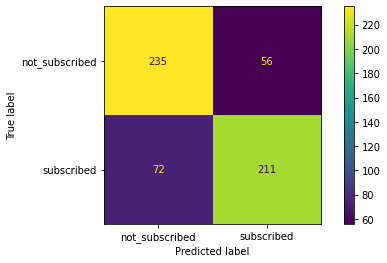

In [135]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, lr_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [136]:
# Print the Classification Report

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       291
         1.0       0.79      0.75      0.77       283

    accuracy                           0.78       574
   macro avg       0.78      0.78      0.78       574
weighted avg       0.78      0.78      0.78       574



In [137]:
# Get the feature importances

feature_importances = pd.DataFrame(lr.coef_).T
feature_importances.rename(columns = {0:'Coefficient'}, inplace = True)
feature_cols = list(data_modeling_balanced.columns)
idx = feature_cols.index('is_subscribed')
feature_cols.pop(idx)
feature_importances['Features'] = feature_cols
feature_importances_sorted = feature_importances.sort_values(by = 'Coefficient', ascending = False)

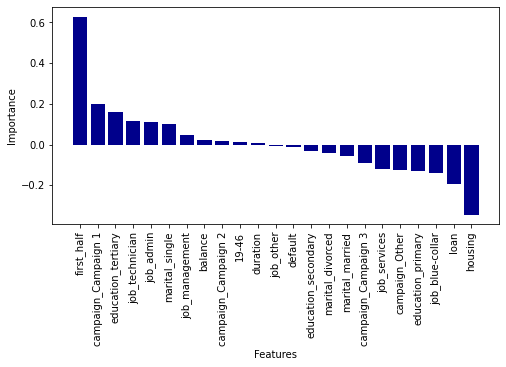

In [138]:
# Plot a bar chart in order to have a better visualization

plt.bar(x = 'Features', height = 'Coefficient', data = feature_importances_sorted, color = 'darkblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation = 90)
plt.show()

In [139]:
# Predict the probabilities

pred_proba_lr = lr.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_lr)

In [140]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_lr)
print(roc_score)

0.8548686750938034


In [141]:
# Define a function to plot the roc curve

def plot_roc_curve(rate1, rate2, c):
    plt.plot(rate1, rate2, color = c)
    plt.plot([0,1], [0,1], color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return plt.show()

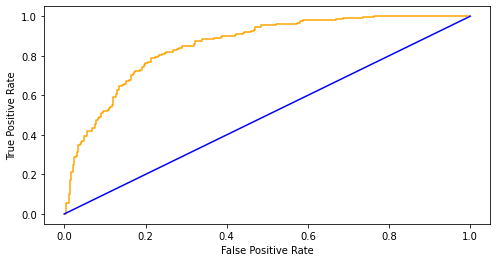

In [142]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

In [143]:
# Evaluate different thresholds

# Define a function to do so 

pred_prob_lr_list = list(pred_proba_lr)

def predictor(threshold):
    predictions = []
    for pred_prob in pred_prob_lr_list:
        if pred_prob < threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions



In [144]:
# Save a data frame with the probabilities

df_test = pd.DataFrame({'Actual Values': y_test})
df_test['Probabilities'] = pred_proba_lr

# Add the new columns witht the selected threshold

df_test['threshold_0.3'] = predictor(threshold = 0.3)
df_test['threshold_0.4'] = predictor(threshold = 0.4)
df_test['threshold_0.5'] = predictor(threshold = 0.5)
df_test['threshold_0.6'] = predictor(threshold = 0.6)

In [145]:
# Print the different accuracy_scores

print('Accuracy Score with a threshold of 0.3: {}'.format(accuracy_score(y_test, df_test['threshold_0.3'])))
print('Accuracy Score with a threshold of 0.4: {}'.format(accuracy_score(y_test, df_test['threshold_0.4'])))
print('Accuracy Score with a threshold of 0.5: {}'.format(accuracy_score(y_test, df_test['threshold_0.5'])))
print('Accuracy Score with a threshold of 0.6: {}'.format(accuracy_score(y_test, df_test['threshold_0.6'])))

Accuracy Score with a threshold of 0.3: 0.740418118466899
Accuracy Score with a threshold of 0.4: 0.7735191637630662
Accuracy Score with a threshold of 0.5: 0.7770034843205574
Accuracy Score with a threshold of 0.6: 0.7543554006968641


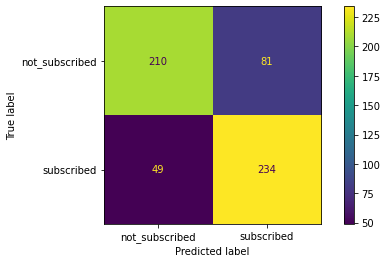

In [146]:
# I reached out the maximum accuracy_score with a threshold of 0.4. However, it is not so much higher.

# Evaluate the model with threshold of 0.4 using a confusion matrix


cm = confusion_matrix(y_test, df_test['threshold_0.4'])
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [147]:
# Print the train score

print('The train score is : {}'.format(lr.score(X_train, y_train)))

The train score is : 0.772093023255814


##### Decision Tree Classifier

In [148]:
param_grid_dt = {'criterion': ['gini', 'entropy'],
             'max_depth': [5, 7, 11, None],
             'min_samples_split': [2, 5, 6],
             }

print(grid_search(model = DecisionTreeClassifier(), grid = param_grid_dt))

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}


In [149]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_split = 2), 
                         X = X_train, y = y_train, cv=5)

print(scores)

[0.79069767 0.79651163 0.77616279 0.80232558 0.80232558]


In [150]:
# Fit and predict the model with the best hyperparamenters

dt, dt_pred = model_fit(model = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_split = 2))

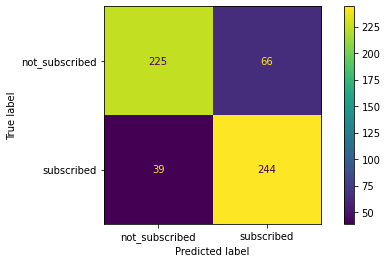

In [151]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, dt_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [152]:
# Print the Classification Report

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81       291
         1.0       0.79      0.86      0.82       283

    accuracy                           0.82       574
   macro avg       0.82      0.82      0.82       574
weighted avg       0.82      0.82      0.82       574



In [153]:
# Define a variable to plot the feature importances for the Classifiers

def plot_feature_importance(model, features, c):
    df = pd.DataFrame(model.feature_importances_)
    df.rename(columns = {0: 'Importance'}, inplace = True)
    df['Features'] = features
    df_sorted = df.sort_values(by = 'Importance', ascending = False)
    plt.bar(x = 'Features', height = 'Importance', data = df_sorted, color = c)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation = 90)
    return plt.show()

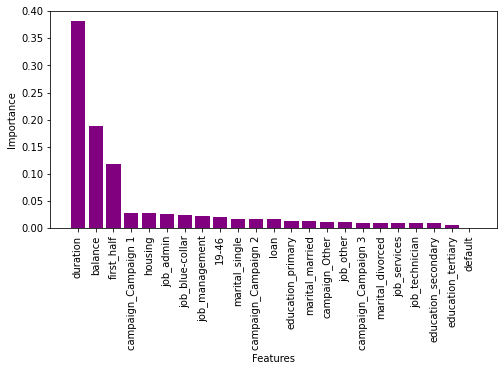

In [154]:
# Plot the feature importance for the Decision Tree Classifier

plot_feature_importance(model = dt, features = feature_cols, c = 'purple')

In [155]:
# Predict the probabilities

pred_proba_dt = dt.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_dt)

In [156]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_dt)
print(roc_score)

0.817693344504754


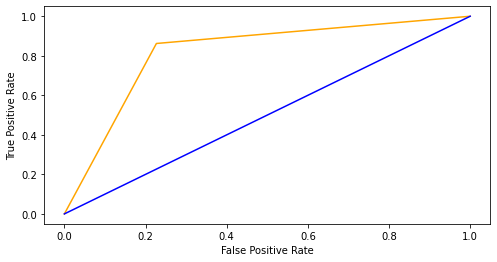

In [157]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

In [158]:
# Print the train score

print('The train score for the Decision Tree Classifier is {}'.format(dt.score(X_train, y_train)))

The train score for the Decision Tree Classifier is 1.0


###### Random Forest Classifier

In [159]:
param_grid_rf = {'n_estimators': [100, 250],
             'criterion': ['gini', 'entropy'],
             'max_depth': [7, 11, None],
            'min_samples_split': [2, 4, 6, 8]
             }

print(grid_search(model = RandomForestClassifier(), grid = param_grid_rf))

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 250}


In [160]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = RandomForestClassifier(criterion = 'entropy', max_depth = None, min_samples_split = 4,
                                                  n_estimators = 250), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[0.84883721 0.84593023 0.83139535 0.85465116 0.84593023]


In [161]:
# Fit and predict the model with the best hyperparamenters

rf, rf_pred = model_fit(model = RandomForestClassifier(criterion = 'entropy', max_depth = None, min_samples_split = 4,
                                                  n_estimators = 250))

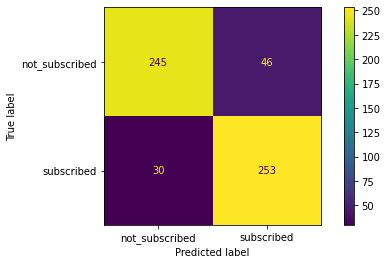

In [162]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, rf_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [163]:
# Print the Classification Report

print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.84      0.87       291
         1.0       0.85      0.89      0.87       283

    accuracy                           0.87       574
   macro avg       0.87      0.87      0.87       574
weighted avg       0.87      0.87      0.87       574



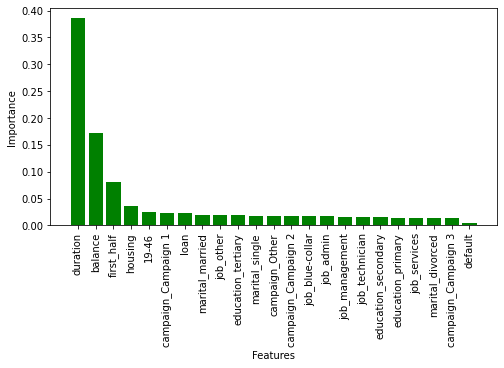

In [164]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = rf, features = feature_cols, c = 'green')

In [165]:
# Plot of the ROC curve

pred_proba_rf = rf.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_rf)

In [166]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_rf)
print(roc_score)

0.9318057629958836


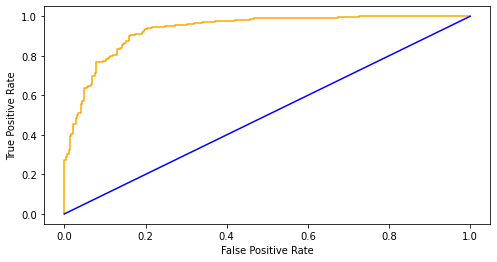

In [167]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

In [168]:
# Print the train score

print('The train score for the Random Forest Classifier is : {}'.format(rf.score(X_train, y_train)))

The train score for the Random Forest Classifier is : 0.9843023255813953


##### Extra Trees Classifier

In [169]:
# Establish the parameter grid and the GridSearchCV

param_grid_et = {'n_estimators': [100, 250],
             'criterion': ['gini', 'entropy'],
             'max_depth': [7, 11, None],
            'min_samples_split': [2, 4, 6, 8]
             }

print(grid_search(model = ExtraTreesClassifier(), grid = param_grid_et))

{'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 250}


In [170]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = ExtraTreesClassifier(criterion = 'gini', max_depth = 11, min_samples_split = 2, 
                                                n_estimators = 250), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[0.81976744 0.8255814  0.80232558 0.81976744 0.82848837]


In [171]:
# Fit and predict the model with the best hyperparamenters

et, et_pred = model_fit(model = ExtraTreesClassifier(criterion = 'gini', max_depth = None, min_samples_split = 4, 
                                                n_estimators = 250))

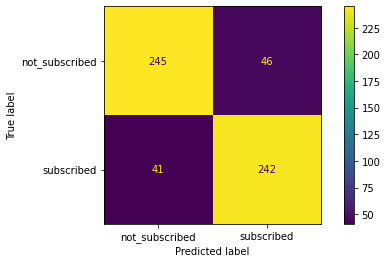

In [172]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, et_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [173]:
# Print the Classification Report

print(classification_report(y_test, et_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       291
         1.0       0.84      0.86      0.85       283

    accuracy                           0.85       574
   macro avg       0.85      0.85      0.85       574
weighted avg       0.85      0.85      0.85       574



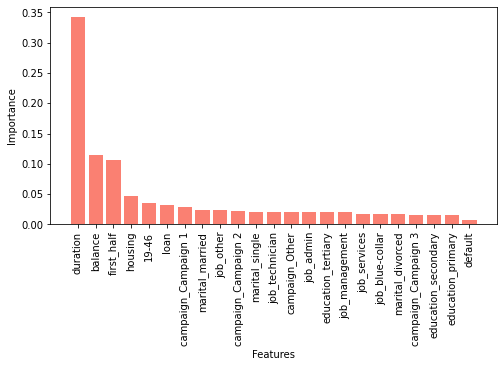

In [174]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = et, features = feature_cols, c = 'salmon')

In [175]:
# Predict the probabilities

pred_proba_et = et.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_et)

In [176]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_et)
print(roc_score)

0.9238521972484304


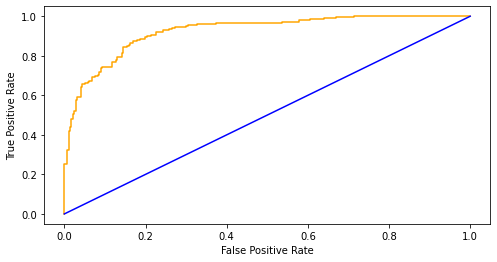

In [177]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

In [178]:
# Print the train score

print('The train score for the Extra Tree Classifier is : {}'.format(rf.score(X_train, y_train)))

The train score for the Extra Tree Classifier is : 0.9843023255813953


##### Gradient Boosting Classifier

In [181]:
param_grid_gb = {'learning_rate': [0.01,0.1],
                 'n_estimators': [300],
                 'tol': [0.01, 0.1, 1.0]
                }

print(grid_search(model = GradientBoostingClassifier(), grid = param_grid_gb))

{'learning_rate': 0.1, 'n_estimators': 300, 'tol': 0.01}


In [182]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, tol = 0.01), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[0.84593023 0.84011628 0.81104651 0.84011628 0.80813953]


In [183]:
# Fit and predict the model with the best hyperparamenters

gb, gb_pred = model_fit(model = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, tol = 0.01))

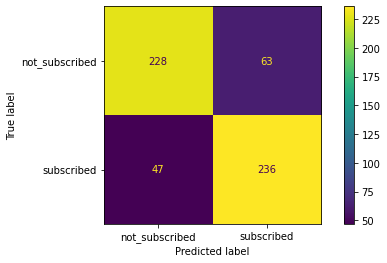

In [184]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, gb_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [185]:
# Print the Classification Report

print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.81       291
         1.0       0.79      0.83      0.81       283

    accuracy                           0.81       574
   macro avg       0.81      0.81      0.81       574
weighted avg       0.81      0.81      0.81       574



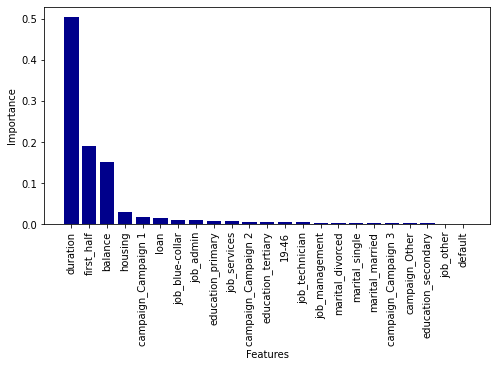

In [186]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = gb, features = feature_cols, c = 'darkblue')

In [187]:
# Predict the Probabilities

pred_proba_gb = gb.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_gb)

In [188]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_gb)
print(roc_score)

0.8910057921387199


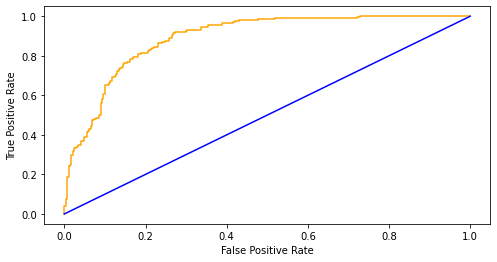

In [189]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

##### Adaboost Classifier

In [190]:
# Establish the parameter grid and the GridSearchCV

param_grid_ab = {'base_estimator': [DecisionTreeClassifier(), LogisticRegression(), ExtraTreesClassifier()],
                 'n_estimators':[50, 100],
                 'learning_rate': [0.1, 1.0]
                }
                
print(grid_search(model = AdaBoostClassifier(), grid = param_grid_ab))

{'base_estimator': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), 'learning_rate': 0.1, 'n_estimators': 50}


In [191]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = AdaBoostClassifier(base_estimator = ExtraTreesClassifier(criterion = 'gini'), 
                                                   learning_rate = 0.1, n_estimators = 300), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[0.83139535 0.8255814  0.79651163 0.81976744 0.8255814 ]


In [192]:
# Fit and predict the model with the best hyperparamenters

ab, ab_pred = model_fit(model = AdaBoostClassifier(base_estimator = ExtraTreesClassifier(criterion = 'gini'), 
                                                   learning_rate = 0.1, n_estimators = 300))

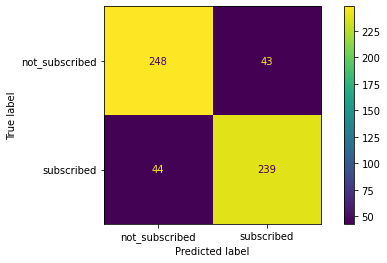

In [193]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, ab_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [194]:
# Print the Classification Report

print(classification_report(y_test, ab_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       291
         1.0       0.85      0.84      0.85       283

    accuracy                           0.85       574
   macro avg       0.85      0.85      0.85       574
weighted avg       0.85      0.85      0.85       574



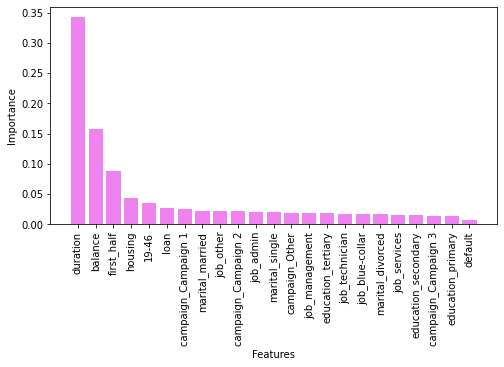

In [195]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = ab, features = feature_cols, c = 'violet')

In [196]:
# Predict the Probabilities

pred_proba_ab = ab.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_ab)

In [197]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_ab)
print(roc_score)

0.932819690843078


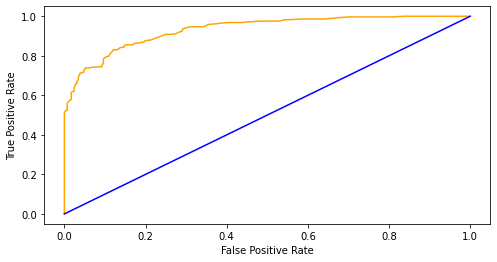

In [198]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

##### Light Gradient Boosting Machine

In [199]:
# Establish the parameter grid and the GridSearchCV

param_grid_lg = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                 'learning_rate': [0.1, 1.0]
                }
                
print(grid_search(model = LGBMClassifier(), grid = param_grid_lg))

{'boosting_type': 'gbdt', 'learning_rate': 0.1}


In [200]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.1), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[0.84593023 0.84593023 0.82848837 0.81976744 0.82267442]


In [201]:
# Fit and predict the model with the best hyperparamenters

lg, lg_pred = model_fit(model = LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.1))

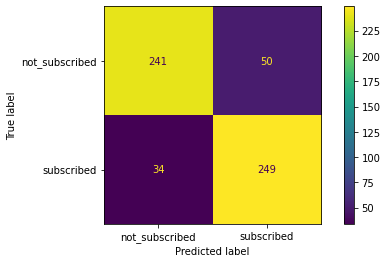

In [202]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, lg_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [203]:
# Print the Classification Report

print(classification_report(y_test, lg_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       291
         1.0       0.83      0.88      0.86       283

    accuracy                           0.85       574
   macro avg       0.85      0.85      0.85       574
weighted avg       0.85      0.85      0.85       574



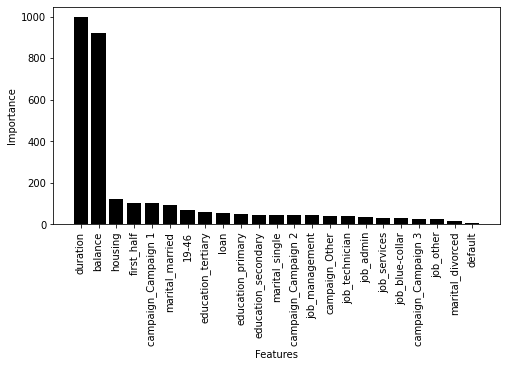

In [204]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = lg, features = feature_cols, c = 'black')

In [205]:
# Predict the Probabilities

pred_proba_lg = ab.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_lg)

In [206]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_lg)
print(roc_score)

0.932819690843078


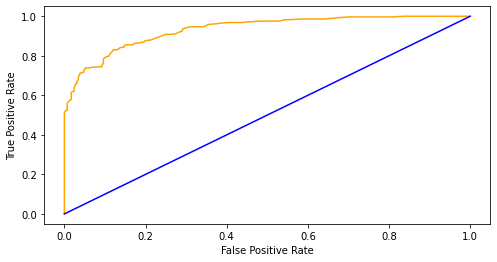

In [207]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

##### Extreme Gradient Boosting Classifier

In [208]:
# Establish the parameter grid and the GridSearchCV

param_grid_eg = {'n_estimators': [100, 300],
                 'max_depth': [3, 5, 7, None],
                 'learning_rate': [0.1, 1.0],
                 'gamma': [0.1, 1.0],
                }
                
print(grid_search(model = XGBClassifier(), grid = param_grid_eg))

[00:23:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[00:24:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[00:24:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[00:24:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[00:24:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[00:25:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [209]:
# Report Cross Validation Scores

scores = cross_val_score(estimator = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 7, n_estimators = 300), 
                         X = X_train, y = y_train, cv=5)
print(scores)

[00:25:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [210]:
# Fit and predict the model with the best hyperparamenters

eg, eg_pred = model_fit(model = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 7, n_estimators = 300))

[00:26:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


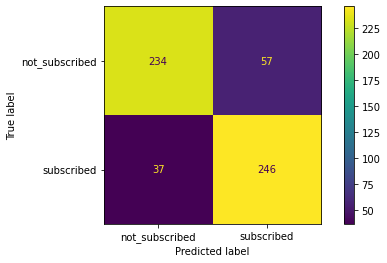

In [211]:
# Evaluate the model using a confusion matrix

cm = confusion_matrix(y_test, eg_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_subscribed','subscribed'])
cmd.plot()

plt.show()

In [212]:
# Print the Classification Report

print(classification_report(y_test, eg_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       291
         1.0       0.81      0.87      0.84       283

    accuracy                           0.84       574
   macro avg       0.84      0.84      0.84       574
weighted avg       0.84      0.84      0.84       574



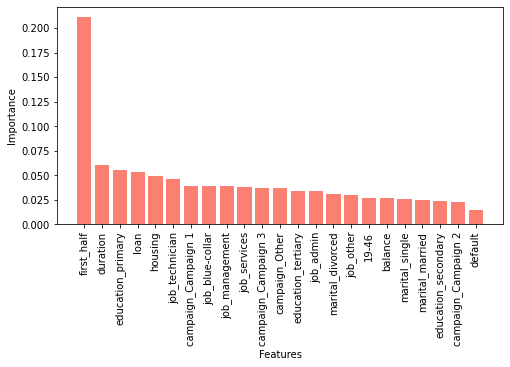

In [213]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = eg, features = feature_cols, c = 'salmon')

In [214]:
# Predict the Probabilities

pred_proba_eg = eg.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, pred_proba_eg)

In [215]:
# Print the roc_auc_score

roc_score = roc_auc_score(y_test, pred_proba_eg)
print(roc_score)

0.910859349386179


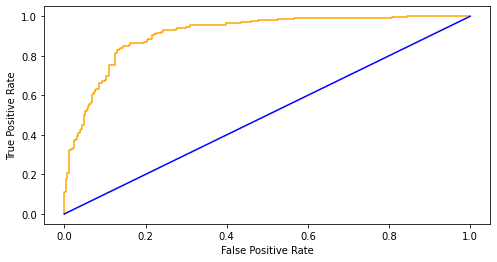

In [216]:
# Plot the roc_curve

plot_roc_curve(rate1 = false_positive_rate, rate2 = true_positive_rate, c = 'orange')

### Key Insights

From all the models I ran, Random Forest Classifier was the one that generally performed the best. Therefore, in order to use the model to predict if a customer would be subscribed to the annuality, I'd go for the Random Forest Classifier to do so.

In this plot, I'm showing again what are the most important features according to the Random Forest Classifier

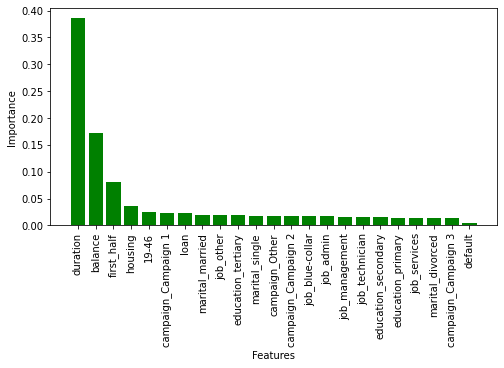

In [217]:
# Plot the feature importance for the Random Forest Classifier

plot_feature_importance(model = rf, features = feature_cols, c = 'green')

##### Duration of the last call , balance, and the season of the year are the most important features to solve this classification problem.

##### The other variables are not that important as the previously mentioned features.

##### The main focus (and the other models also supported that excepting the Extreme Gradient Boosting Classifier) the company should be focusing on is the duration of the last call. This variable highly determines if a customer is going to subscribe or not. 

##### Additionally, during the first 6 months of year is when customers tend to subscribe. It would be a good idea to focus on this part of the season to get more subscriptions and also focusing on the duration of the last call. (It is also important to say that the duration is probably more because agents need to disclose all the information properly and that takes more time). 

###### Many models support that it is also important to quickly check the customers with higher balances because they may subscribe (Also because any annuality means an increase on the balance since they cannot withdraw the funds whenever they want).

###### If the customer has their own focus could also be an important factor. The company should also see what are the customers with their own house to convice them to have the subscription. 